In [1]:
from joblib import load
import sys
from Sparse_vector.sparse_vector import SparseVector
from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve

In [2]:
import urllib.request

url = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes"
filename = "hg38.chrom.sizes"

urllib.request.urlretrieve(url, filename)
chrom_sizes_file = "hg38.chrom.sizes"

def get_chrom_sizes():
    chrom_sizes = {}
    with open(chrom_sizes_file) as f:
        for line in f:
            name, size = line.strip().split("\t")
            chrom_sizes[name] = int(size)
    return chrom_sizes
  
chr_size = get_chrom_sizes()

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('blood/')]
groups = ['Histone', 'TFs']
feature_names = [i for i in features if (i.split('_')[0] in groups)]
DNA_features = {feture: load(f'blood/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/24 [00:00<?, ?it/s]

In [4]:
from collections import defaultdict

result_dict = defaultdict(set)
with open("blood.bed", "r") as bed_file:
    for line in bed_file:
        chrom, start, end = line.strip().split("\t")[:3]
        start, end = int(start), int(end)
        result_dict[chrom].update(set(range(start, end+1)))


In [5]:
from tqdm import tqdm
win_in = []
win_out = []
width = 5000
ws = [-20*width, -10*width, -5*width, 5*width, 10*width, 20*width]

for chrm in tqdm(chrom_names):
    first_time = True
    for pos in result_dict[chrm]:  
        win_in.append([chrm, max(pos - width//2, 0), min(pos + width//2, chr_size[chrm])])
        for w in ws:
            if w < 0:
                w = abs(w)
                pos -= w
            else:
                pos += w
            interval = [min(max(pos - width//2, 0), chr_size[chrm]), max(0, min(pos + width//2, chr_size[chrm]))]
            is_in = False
            for i in range(interval[0], interval[1]+1):
                if interval[0] + i in result_dict[chrm]:
                    is_in = True
                    break
            if not is_in and interval[0] != interval[1]:
                win_out.append([chrm, interval[0], interval[1]])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.54it/s]


In [6]:
win_in[:10]

[['chr1', 158947389, 158952389],
 ['chr1', 119180607, 119185607],
 ['chr1', 47319616, 47324616],
 ['chr1', 203789121, 203794121],
 ['chr1', 223377730, 223382730],
 ['chr1', 167561283, 167566283],
 ['chr1', 148271684, 148276684],
 ['chr1', 242949187, 242954187],
 ['chr1', 9058886, 9063886],
 ['chr1', 72170822, 72175822]]

In [7]:
win_out[:10]

[['chr1', 158847389, 158852389],
 ['chr1', 158797389, 158802389],
 ['chr1', 158772389, 158777389],
 ['chr1', 158797389, 158802389],
 ['chr1', 158847389, 158852389],
 ['chr1', 158947389, 158952389],
 ['chr1', 119080607, 119085607],
 ['chr1', 119030607, 119035607],
 ['chr1', 119005607, 119010607],
 ['chr1', 119030607, 119035607]]

In [ ]:
print(len(win_in), len(win_out))

1761 10553


In [ ]:
ints_in1 = np.array(win_in)
ints_out1 = np.array(win_out)[np.random.choice(range(len(win_out)), size=len(win_in)*2, replace=False)]
#ints_out1 = np.array(win_out)

In [ ]:
print(len(ints_in1), len(ints_out1))

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

equalized1 = [[inter[0], int(inter[1]), int(inter[2]), 1] for inter in ints_in1]
equalized0 = [[inter[0], int(inter[1]), int(inter[2]), 0] for inter in ints_out1]
equalized = np.vstack((equalized1, equalized0))

np.random.shuffle(equalized)
equalized[0:10]

In [12]:
import numpy as np
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
X = []
y = []

pbar = tqdm(total=len(equalized))

for idx in range(len(equalized)):
    pbar.update(1)
    inter = equalized[idx]
    chrom = inter[0]
    begin = int(inter[1])
    end = int(inter[2])
    target = int(inter[3])
    feature_matr = []
    for feature in feature_names:
        source = DNA_features[feature]
        feature_matr.append(source[chrom][begin:end].mean())

    if len(feature_matr) > 0:
        new_row = np.hstack(np.array(feature_matr).T).astype(np.float32)
        X.append(new_row)
        y.append(target)
    else:
        continue 

pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5283/5283 [00:02<00:00, 1804.63it/s]


In [13]:
X = np.array(X)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X = torch.tensor(X_normalized, dtype=torch.float)
y = torch.tensor(y, dtype=torch.int64)

In [14]:
X = np.array(X)
X

array([[-0.03045881, -0.06451403, -0.0472311 , ..., -0.08106954,
         1.7048216 ,  0.5215339 ],
       [-0.03045881, -0.06451403, -0.0472311 , ..., -0.08106954,
        -0.16530877,  0.11944623],
       [-0.03045881, -0.06451403, -0.0472311 , ..., -0.08106954,
        -0.00364282,  0.05328915],
       ...,
       [-0.03045881, -0.06451403, -0.0472311 , ..., -0.08106954,
         0.08871511, -0.1179898 ],
       [-0.03045881, -0.06451403, -0.0472311 , ..., -0.08106954,
        -0.06270962, -0.01314782],
       [-0.03045881, -0.06451403, -0.0472311 , ..., -0.08106954,
         0.16572621, -0.84144366]], dtype=float32)

In [15]:
X.shape

(5283, 24)

In [16]:
y

tensor([1, 1, 1,  ..., 0, 0, 0])

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC score: {:.4f}".format(roc_auc))


2023-05-16 15:20:04.986825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 15:20:05.639246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 0.6402 - accuracy: 0.6668 - val_loss: 0.6369 - val_accuracy: 0.6632
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 0.6359 - accuracy: 0.6675 - val_loss: 0.6369 - val_accuracy: 0.6632
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 0.6358 - accuracy: 0.6675 - val_loss: 0.6364 - val_accuracy: 0.6632
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 0.6352 - accuracy: 0.6675 - val_loss: 0.6386 - val_accuracy: 0.6632
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 0.6356 - accuracy: 0.6675 - val_loss: 0.6373 - val_accuracy: 0.6632
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 0.6354 - accuracy: 0.6675 - val_loss: 0.6368 - val_accuracy: 0.6632
Epoch 7/10
133/133 [==============================] - 0s 2ms/step - loss: 0.6354 - accuracy: 0.6675 - val_loss: 0.6375 - val_accuracy: 0.6632
Epoch 

In [ ]:
from copy import deepcopy
X_copy = deepcopy(X)
y_copy = deepcopy(y)

In [22]:
X = X_copy
y = y_copy

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        if np.array(true_labels).std() == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_2061/3757297636.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_2061/3757297636.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6432, Train F1-score: 0.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 1.0000, Test Loss: 0.6391, Test F1-score: 0.5340, Test ROC-AUC: 0.5239, Test PR-AUC: 0.3565
Epoch [2/20], Train Loss: 0.6319, Train F1-score: 0.3333, Train ROC-AUC: 0.0000, Train PR-AUC: 0.2500, Test Loss: 0.6444, Test F1-score: 0.5467, Test ROC-AUC: 0.5207, Test PR-AUC: 0.3518
Epoch [3/20], Train Loss: 0.6325, Train F1-score: 0.3333, Train ROC-AUC: 0.0000, Train PR-AUC: 0.2500, Test Loss: 0.6412, Test F1-score: 0.5417, Test ROC-AUC: 0.5159, Test PR-AUC: 0.3498
Epoch [4/20], Train Loss: 0.6300, Train F1-score: 0.3333, Train ROC-AUC: 0.0000, Train PR-AUC: 0.2500, Test Loss: 0.6424, Test F1-score: 0.5463, Test ROC-AUC: 0.5190, Test PR-AUC: 0.3589
Epoch [5/20], Train Loss: 0.6307, Train F1-score: 0.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 1.0000, Test Loss: 0.6440, Test F1-score: 0.5483, Test ROC-AUC: 0.5100, Test PR-AUC: 0.3494
Epoch [6/20], Train Loss: 0.6281, Train F1-score: 0.3333, Train R

/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [13/20], Train Loss: 0.6213, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6575, Test F1-score: 0.5508, Test ROC-AUC: 0.5154, Test PR-AUC: 0.3559


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [14/20], Train Loss: 0.6187, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6654, Test F1-score: 0.5473, Test ROC-AUC: 0.5169, Test PR-AUC: 0.3564
Epoch [15/20], Train Loss: 0.6204, Train F1-score: 0.3333, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6586, Test F1-score: 0.5462, Test ROC-AUC: 0.5161, Test PR-AUC: 0.3555
Epoch [16/20], Train Loss: 0.6199, Train F1-score: 0.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 1.0000, Test Loss: 0.6664, Test F1-score: 0.5497, Test ROC-AUC: 0.5179, Test PR-AUC: 0.3589
Epoch [17/20], Train Loss: 0.6185, Train F1-score: 0.3333, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6681, Test F1-score: 0.5486, Test ROC-AUC: 0.5201, Test PR-AUC: 0.3623
Epoch [18/20], Train Loss: 0.6174, Train F1-score: 0.3333, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6687, Test F1-score: 0.5422, Test ROC-AUC: 0.5183, Test PR-AUC: 0.3569
Epoch [19/20], Train Loss: 0.6159, Train F1-score: 0.3333, T

/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


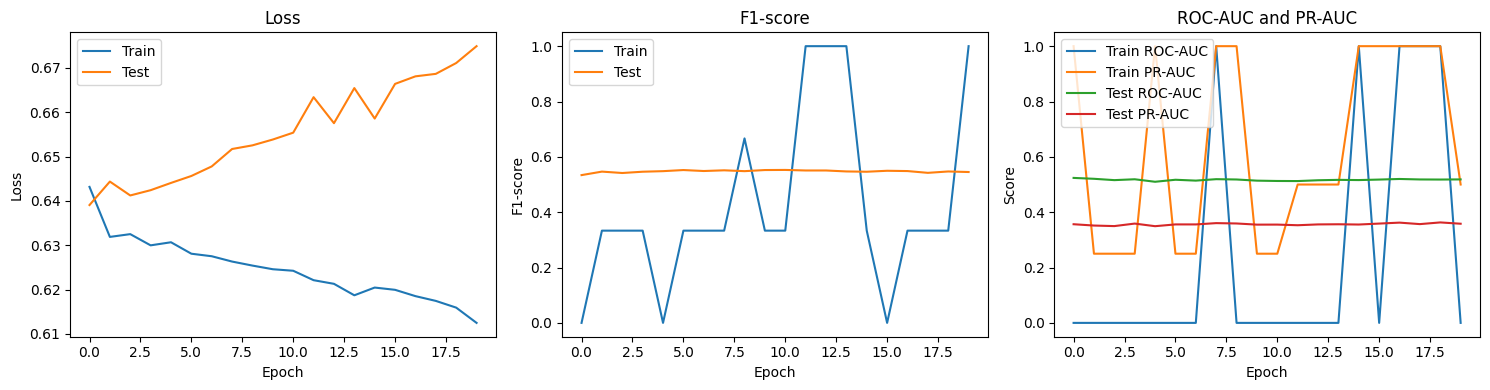

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1)

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 1
num_epochs = 20
batch_size = 64
learning_rate = 0.0001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().detach().numpy()
        predicted_probs.extend(probs)
        preds = (probs > 0.5).astype(int)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds)

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = torch.sigmoid(test_outputs).cpu().detach().numpy()
        test_predicted_probs = probs
        test_preds = (probs > 0.5).astype(int)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds, average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)



/tmp/ipykernel_2061/1626131257.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)  # Изменение: тип данных float
/tmp/ipykernel_2061/1626131257.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)  # Изменение: тип данных float


Epoch [1/20], Train Loss: 0.6907, Train F1-score: 0.5536, Train ROC-AUC: 0.5096, Train PR-AUC: 0.3538, Test Loss: 0.6837, Test F1-score: 0.5473, Test ROC-AUC: 0.4904, Test PR-AUC: 0.3365
Epoch [2/20], Train Loss: 0.6755, Train F1-score: 0.5392, Train ROC-AUC: 0.5060, Train PR-AUC: 0.3410, Test Loss: 0.6681, Test F1-score: 0.5412, Test ROC-AUC: 0.5042, Test PR-AUC: 0.3457
Epoch [3/20], Train Loss: 0.6594, Train F1-score: 0.5441, Train ROC-AUC: 0.5105, Train PR-AUC: 0.3514, Test Loss: 0.6533, Test F1-score: 0.5422, Test ROC-AUC: 0.5112, Test PR-AUC: 0.3487
Epoch [4/20], Train Loss: 0.6440, Train F1-score: 0.5435, Train ROC-AUC: 0.4994, Train PR-AUC: 0.3512, Test Loss: 0.6438, Test F1-score: 0.5392, Test ROC-AUC: 0.5137, Test PR-AUC: 0.3498
Epoch [5/20], Train Loss: 0.6374, Train F1-score: 0.5436, Train ROC-AUC: 0.5130, Train PR-AUC: 0.3556, Test Loss: 0.6402, Test F1-score: 0.5396, Test ROC-AUC: 0.5178, Test PR-AUC: 0.3538
Epoch [6/20], Train Loss: 0.6365, Train F1-score: 0.5430, Train R

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import accuracy_score
def permutation_importance(model, X_test, y_test, metric, feature_names):
    base_score = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test)) > 0.5).cpu().numpy().astype(int))
    feature_importances = []
    X_test_permuted = X_test.clone()
    for i in range(X_test.shape[-1]):
        np.random.shuffle(X_test_permuted[:, :, i].cpu().numpy())
        score_permuted = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test_permuted)) > 0.5).cpu().numpy().astype(int))
        feature_importances.append(base_score - score_permuted)
        X_test_permuted = X_test.clone() 
    
    feature_importance_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_importances

feat_names = feature_names

sorted_feature_importances = permutation_importance(model, X_test, y_test, accuracy_score, feat_names)

for name, imp in sorted_feature_importances:
    print(f'Feature {name} importance: {imp}')


Feature Histone_H2A.XS139ph importance: 0.0018921475875117721
Feature Histone_H3K18ac importance: 0.0018921475875117721
Feature Histone_H3K27me3 importance: 0.0018921475875117721
Feature Histone_H2AK119Ub importance: 0.0009460737937558861
Feature Histone_H2Bub importance: 0.0009460737937558861
Feature Histone_H3.3 importance: 0.0009460737937558861
Feature Histone_H3K27me1 importance: 0.0009460737937558861
Feature Histone_CENPA importance: 0.0
Feature Histone_H1.2 importance: 0.0
Feature Histone_H1.5 importance: 0.0
Feature Histone_H2AK120Ub importance: 0.0
Feature Histone_H2A.X importance: 0.0
Feature Histone_H2A.Zac importance: 0.0
Feature Histone_H2A.Z importance: 0.0
Feature Histone_H2BK20ac importance: 0.0
Feature Histone_H2 importance: 0.0
Feature Histone_H3K122ac importance: 0.0
Feature Histone_H3K14ac importance: 0.0
Feature Histone_H3K14cr importance: 0.0
Feature Histone_H3K23ac importance: 0.0
Feature Histone_H3K27me2 importance: 0.0
Feature Histone_H3K28ac importance: 0.0
Fea

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torch.nn.functional as F

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        if np.array(true_labels).std() == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_2061/3146516767.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_2061/3146516767.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6413, Train F1-score: 0.3333, Train ROC-AUC: 0.0000, Train PR-AUC: 0.2500, Test Loss: 0.6411, Test F1-score: 0.5396, Test ROC-AUC: 0.5261, Test PR-AUC: 0.3545
Epoch [2/20], Train Loss: 0.6360, Train F1-score: 0.3333, Train ROC-AUC: 0.0000, Train PR-AUC: 0.2500, Test Loss: 0.6409, Test F1-score: 0.5292, Test ROC-AUC: 0.5158, Test PR-AUC: 0.3457
Epoch [3/20], Train Loss: 0.6358, Train F1-score: 0.3333, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6414, Test F1-score: 0.5411, Test ROC-AUC: 0.5170, Test PR-AUC: 0.3502
Epoch [4/20], Train Loss: 0.6337, Train F1-score: 0.3333, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6411, Test F1-score: 0.5380, Test ROC-AUC: 0.5290, Test PR-AUC: 0.3560
Epoch [5/20], Train Loss: 0.6372, Train F1-score: 0.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 1.0000, Test Loss: 0.6390, Test F1-score: 0.5343, Test ROC-AUC: 0.5337, Test PR-AUC: 0.3623
Epoch [6/20], Train Loss: 0.6345, Train F1-score: 0.3333, Train R

/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [10/20], Train Loss: 0.6342, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6404, Test F1-score: 0.5302, Test ROC-AUC: 0.5293, Test PR-AUC: 0.3584


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [11/20], Train Loss: 0.6334, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6420, Test F1-score: 0.5378, Test ROC-AUC: 0.5227, Test PR-AUC: 0.3574


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [12/20], Train Loss: 0.6312, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6411, Test F1-score: 0.5357, Test ROC-AUC: 0.5113, Test PR-AUC: 0.3514


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [13/20], Train Loss: 0.6323, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6403, Test F1-score: 0.5420, Test ROC-AUC: 0.5204, Test PR-AUC: 0.3559
Epoch [14/20], Train Loss: 0.6326, Train F1-score: 0.3333, Train ROC-AUC: 0.0000, Train PR-AUC: 0.2500, Test Loss: 0.6434, Test F1-score: 0.5422, Test ROC-AUC: 0.5212, Test PR-AUC: 0.3530


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [15/20], Train Loss: 0.6329, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6418, Test F1-score: 0.5401, Test ROC-AUC: 0.5143, Test PR-AUC: 0.3501


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [16/20], Train Loss: 0.6322, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6421, Test F1-score: 0.5411, Test ROC-AUC: 0.5230, Test PR-AUC: 0.3592
Epoch [17/20], Train Loss: 0.6337, Train F1-score: 1.0000, Train ROC-AUC: 1.0000, Train PR-AUC: 1.0000, Test Loss: 0.6429, Test F1-score: 0.5359, Test ROC-AUC: 0.5125, Test PR-AUC: 0.3484


/home/eparo/venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch [18/20], Train Loss: 0.6322, Train F1-score: 1.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 0.5000, Test Loss: 0.6419, Test F1-score: 0.5357, Test ROC-AUC: 0.5153, Test PR-AUC: 0.3520
Epoch [19/20], Train Loss: 0.6350, Train F1-score: 0.0000, Train ROC-AUC: 0.0000, Train PR-AUC: 1.0000, Test Loss: 0.6399, Test F1-score: 0.5362, Test ROC-AUC: 0.5155, Test PR-AUC: 0.3538
Epoch [20/20], Train Loss: 0.6331, Train F1-score: 0.3333, Train ROC-AUC: 0.0000, Train PR-AUC: 0.2500, Test Loss: 0.6414, Test F1-score: 0.5323, Test ROC-AUC: 0.5221, Test PR-AUC: 0.3581


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs[:, 1] > 0.5).long()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        softmax = nn.Softmax(dim=1)
        probs = softmax(outputs)
        predicted_probs.extend(probs[:, 1].detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_probs = softmax(test_outputs)
        test_preds = (test_probs[:, 1] > 0.5).long()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        softmax = nn.Softmax(dim=1)
        test_probs = softmax(test_outputs)
        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_2061/1862407589.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_2061/1862407589.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6455, Train F1-score: 0.5399, Train ROC-AUC: 0.5139, Train PR-AUC: 0.3440, Test Loss: 0.6398, Test F1-score: 0.5426, Test ROC-AUC: 0.5365, Test PR-AUC: 0.3635
Epoch [2/20], Train Loss: 0.6336, Train F1-score: 0.5465, Train ROC-AUC: 0.5295, Train PR-AUC: 0.3729, Test Loss: 0.6388, Test F1-score: 0.5383, Test ROC-AUC: 0.5185, Test PR-AUC: 0.3597
Epoch [3/20], Train Loss: 0.6313, Train F1-score: 0.5489, Train ROC-AUC: 0.5476, Train PR-AUC: 0.3869, Test Loss: 0.6392, Test F1-score: 0.5463, Test ROC-AUC: 0.5201, Test PR-AUC: 0.3604
Epoch [4/20], Train Loss: 0.6290, Train F1-score: 0.5552, Train ROC-AUC: 0.5461, Train PR-AUC: 0.3929, Test Loss: 0.6407, Test F1-score: 0.5534, Test ROC-AUC: 0.5186, Test PR-AUC: 0.3593
Epoch [5/20], Train Loss: 0.6277, Train F1-score: 0.5609, Train ROC-AUC: 0.5595, Train PR-AUC: 0.4012, Test Loss: 0.6406, Test F1-score: 0.5499, Test ROC-AUC: 0.5182, Test PR-AUC: 0.3605
Epoch [6/20], Train Loss: 0.6273, Train F1-score: 0.5628, Train R

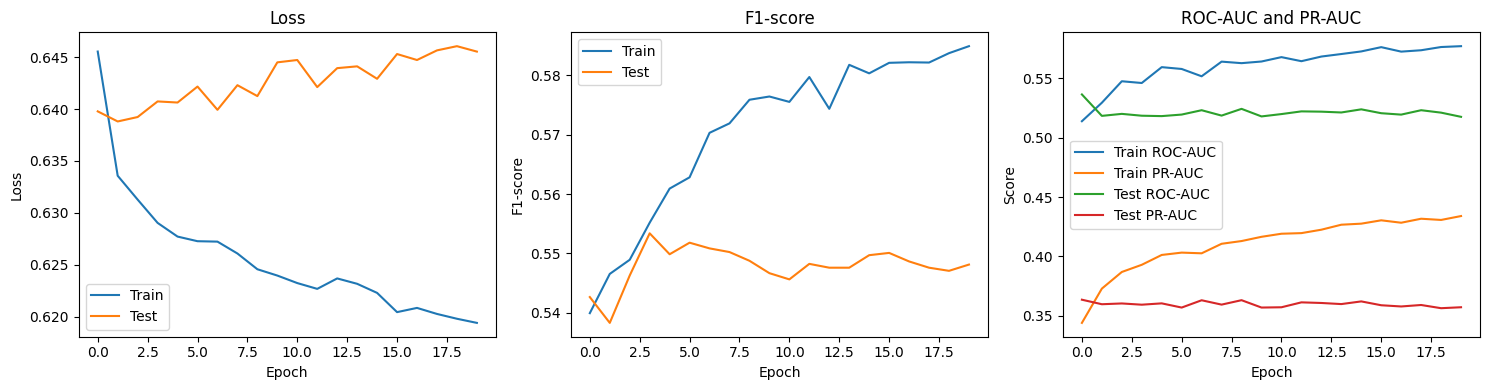

In [32]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out.squeeze()

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_epochs = 30
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

dropout_prob = 0.5
train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs > 0.5).float()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        predicted_probs.extend(outputs.detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_preds = (test_outputs > 0.5).float()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_2061/792856689.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)
/tmp/ipykernel_2061/792856689.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)


Epoch [1/30], Train Loss: 0.6443, Train F1-score: 0.5374, Train ROC-AUC: 0.5111, Train PR-AUC: 0.3436, Test Loss: 0.6421, Test F1-score: 0.5343, Test ROC-AUC: 0.5306, Test PR-AUC: 0.3583
Epoch [2/30], Train Loss: 0.6326, Train F1-score: 0.5466, Train ROC-AUC: 0.5425, Train PR-AUC: 0.3763, Test Loss: 0.6391, Test F1-score: 0.5345, Test ROC-AUC: 0.5229, Test PR-AUC: 0.3587
Epoch [3/30], Train Loss: 0.6329, Train F1-score: 0.5476, Train ROC-AUC: 0.5342, Train PR-AUC: 0.3774, Test Loss: 0.6410, Test F1-score: 0.5426, Test ROC-AUC: 0.5189, Test PR-AUC: 0.3548
Epoch [4/30], Train Loss: 0.6305, Train F1-score: 0.5557, Train ROC-AUC: 0.5497, Train PR-AUC: 0.3938, Test Loss: 0.6416, Test F1-score: 0.5473, Test ROC-AUC: 0.5138, Test PR-AUC: 0.3574
Epoch [5/30], Train Loss: 0.6294, Train F1-score: 0.5534, Train ROC-AUC: 0.5561, Train PR-AUC: 0.3949, Test Loss: 0.6427, Test F1-score: 0.5422, Test ROC-AUC: 0.5174, Test PR-AUC: 0.3592
Epoch [6/30], Train Loss: 0.6292, Train F1-score: 0.5547, Train R

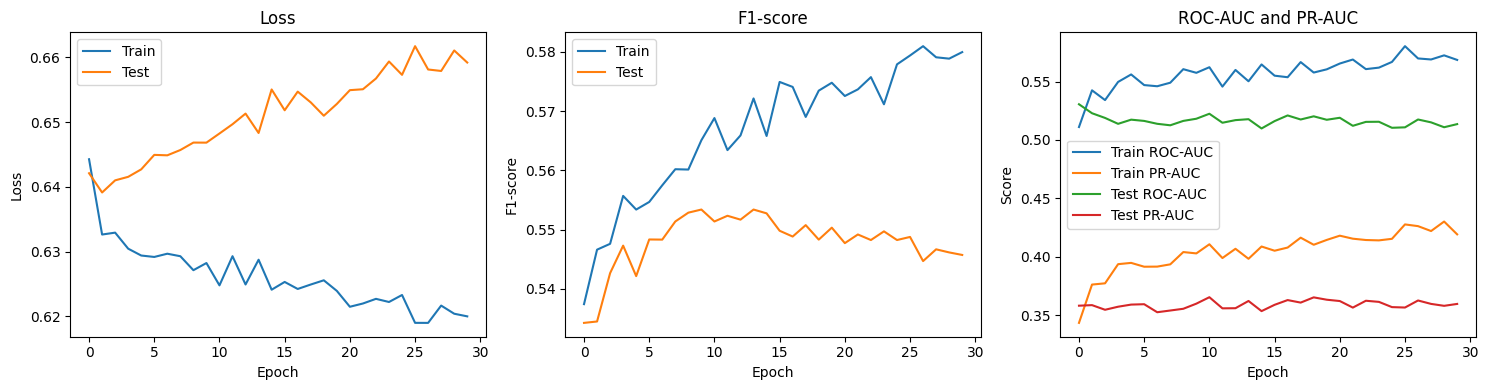

In [34]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 256
num_layers = 3
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(tqdm(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = nn.functional.softmax(test_outputs, dim=1)
        test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
        _, test_preds = torch.max(test_outputs, 1)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)

/tmp/ipykernel_2061/140274637.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_2061/140274637.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 75.75it/s]


Epoch [1/20], Train Loss: 0.6416, Train F1-score: 0.5393, Train ROC-AUC: 0.4998, Train PR-AUC: 0.3384, Test Loss: 0.6433, Test F1-score: 0.5333, Test ROC-AUC: 0.5199, Test PR-AUC: 0.3457


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.63it/s]


Epoch [2/20], Train Loss: 0.6357, Train F1-score: 0.5477, Train ROC-AUC: 0.5253, Train PR-AUC: 0.3654, Test Loss: 0.6439, Test F1-score: 0.5426, Test ROC-AUC: 0.5148, Test PR-AUC: 0.3490


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 77.04it/s]


Epoch [3/20], Train Loss: 0.6336, Train F1-score: 0.5480, Train ROC-AUC: 0.5351, Train PR-AUC: 0.3758, Test Loss: 0.6420, Test F1-score: 0.5458, Test ROC-AUC: 0.5187, Test PR-AUC: 0.3513


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.55it/s]


Epoch [4/20], Train Loss: 0.6321, Train F1-score: 0.5494, Train ROC-AUC: 0.5491, Train PR-AUC: 0.3844, Test Loss: 0.6464, Test F1-score: 0.5373, Test ROC-AUC: 0.5173, Test PR-AUC: 0.3544


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.95it/s]


Epoch [5/20], Train Loss: 0.6322, Train F1-score: 0.5540, Train ROC-AUC: 0.5368, Train PR-AUC: 0.3749, Test Loss: 0.6448, Test F1-score: 0.5415, Test ROC-AUC: 0.5220, Test PR-AUC: 0.3645


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.72it/s]


Epoch [6/20], Train Loss: 0.6305, Train F1-score: 0.5514, Train ROC-AUC: 0.5498, Train PR-AUC: 0.3901, Test Loss: 0.6451, Test F1-score: 0.5378, Test ROC-AUC: 0.5244, Test PR-AUC: 0.3570


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.46it/s]


Epoch [7/20], Train Loss: 0.6309, Train F1-score: 0.5497, Train ROC-AUC: 0.5509, Train PR-AUC: 0.3887, Test Loss: 0.6483, Test F1-score: 0.5473, Test ROC-AUC: 0.5192, Test PR-AUC: 0.3527


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 75.88it/s]


Epoch [8/20], Train Loss: 0.6306, Train F1-score: 0.5552, Train ROC-AUC: 0.5427, Train PR-AUC: 0.3836, Test Loss: 0.6480, Test F1-score: 0.5357, Test ROC-AUC: 0.5127, Test PR-AUC: 0.3540


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 74.38it/s]


Epoch [9/20], Train Loss: 0.6288, Train F1-score: 0.5539, Train ROC-AUC: 0.5486, Train PR-AUC: 0.3926, Test Loss: 0.6473, Test F1-score: 0.5385, Test ROC-AUC: 0.5134, Test PR-AUC: 0.3493


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.36it/s]


Epoch [10/20], Train Loss: 0.6271, Train F1-score: 0.5519, Train ROC-AUC: 0.5589, Train PR-AUC: 0.3991, Test Loss: 0.6561, Test F1-score: 0.5504, Test ROC-AUC: 0.5186, Test PR-AUC: 0.3571


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.72it/s]


Epoch [11/20], Train Loss: 0.6286, Train F1-score: 0.5565, Train ROC-AUC: 0.5510, Train PR-AUC: 0.3963, Test Loss: 0.6555, Test F1-score: 0.5472, Test ROC-AUC: 0.5143, Test PR-AUC: 0.3512


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.47it/s]


Epoch [12/20], Train Loss: 0.6262, Train F1-score: 0.5575, Train ROC-AUC: 0.5624, Train PR-AUC: 0.4045, Test Loss: 0.6593, Test F1-score: 0.5412, Test ROC-AUC: 0.5151, Test PR-AUC: 0.3447


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.81it/s]


Epoch [13/20], Train Loss: 0.6255, Train F1-score: 0.5645, Train ROC-AUC: 0.5464, Train PR-AUC: 0.3976, Test Loss: 0.6620, Test F1-score: 0.5456, Test ROC-AUC: 0.5079, Test PR-AUC: 0.3434


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.72it/s]


Epoch [14/20], Train Loss: 0.6270, Train F1-score: 0.5693, Train ROC-AUC: 0.5494, Train PR-AUC: 0.4000, Test Loss: 0.6474, Test F1-score: 0.5473, Test ROC-AUC: 0.5181, Test PR-AUC: 0.3549


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.55it/s]


Epoch [15/20], Train Loss: 0.6238, Train F1-score: 0.5665, Train ROC-AUC: 0.5598, Train PR-AUC: 0.4051, Test Loss: 0.6548, Test F1-score: 0.5453, Test ROC-AUC: 0.5157, Test PR-AUC: 0.3545


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.75it/s]


Epoch [16/20], Train Loss: 0.6251, Train F1-score: 0.5704, Train ROC-AUC: 0.5580, Train PR-AUC: 0.4062, Test Loss: 0.6607, Test F1-score: 0.5432, Test ROC-AUC: 0.5148, Test PR-AUC: 0.3532


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.83it/s]


Epoch [17/20], Train Loss: 0.6241, Train F1-score: 0.5659, Train ROC-AUC: 0.5596, Train PR-AUC: 0.4079, Test Loss: 0.6546, Test F1-score: 0.5508, Test ROC-AUC: 0.5197, Test PR-AUC: 0.3594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.76it/s]


Epoch [18/20], Train Loss: 0.6237, Train F1-score: 0.5744, Train ROC-AUC: 0.5584, Train PR-AUC: 0.4086, Test Loss: 0.6642, Test F1-score: 0.5480, Test ROC-AUC: 0.5203, Test PR-AUC: 0.3616


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.86it/s]


Epoch [19/20], Train Loss: 0.6233, Train F1-score: 0.5776, Train ROC-AUC: 0.5586, Train PR-AUC: 0.4102, Test Loss: 0.6628, Test F1-score: 0.5483, Test ROC-AUC: 0.5137, Test PR-AUC: 0.3511


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:03<00:00, 76.19it/s]

Epoch [20/20], Train Loss: 0.6223, Train F1-score: 0.5702, Train ROC-AUC: 0.5587, Train PR-AUC: 0.4144, Test Loss: 0.6689, Test F1-score: 0.5493, Test ROC-AUC: 0.5198, Test PR-AUC: 0.3605


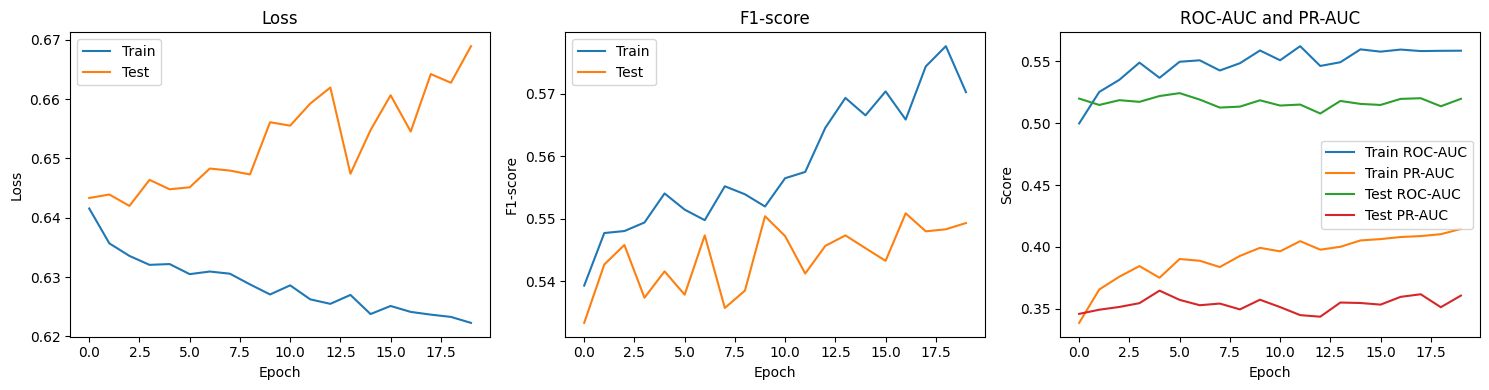

In [ ]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = X.shape[1]
hidden_size = 128
output_size = 2

model = MLP(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

epochs = 50
train_loss_history = []
train_f1_history = []
train_roc_auc_history = []
train_pr_auc_history = []
test_loss_history = []
test_f1_history = []
test_roc_auc_history = []
test_pr_auc_history = []


for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs, 1)
        train_f1 = f1_score(y_train, train_predicted, average='weighted')
        train_loss_history.append(loss.item())
        train_f1_history.append(train_f1)
        train_roc_auc_history.append(roc_auc_score(y_train, train_outputs[:, 1]))
        train_precision, train_recall, _ = precision_recall_curve(y_train, train_outputs[:, 1])
        train_pr_auc_history.append(auc(train_recall, train_precision))

    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_loss = criterion(test_outputs, y_test)
        test_f1 = f1_score(y_test, test_predicted, average='weighted')
        test_loss_history.append(test_loss.item())
        test_f1_history.append(test_f1)
        test_roc_auc = roc_auc_score(y_test, test_outputs[:, 1])
        test_roc_auc_history.append(test_roc_auc)
        test_precision, test_recall, _ = precision_recall_curve(y_test, test_outputs[:, 1])
        test_pr_auc = auc(test_recall, test_precision)
        test_pr_auc_history.append(test_pr_auc)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train F1-score: {train_f1:.4f}, Train ROC-AUC: {train_roc_auc_history[-1]:.4f}, Train PR-AUC: {train_pr_auc_history[-1]:.4f}, Test Loss: {test_loss.item():.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc_history[-1]:.4f}, Test PR-AUC: {test_pr_auc_history[-1]:.4f}')

Epoch [1/50], Train Loss: 0.6959, Train F1-score: 0.5761, Train ROC-AUC: 0.5044, Train PR-AUC: 0.3414, Test Loss: 0.6849, Test F1-score: 0.5803, Test ROC-AUC: 0.4860, Test PR-AUC: 0.3391
Epoch [2/50], Train Loss: 0.6890, Train F1-score: 0.5577, Train ROC-AUC: 0.5037, Train PR-AUC: 0.3409, Test Loss: 0.6800, Test F1-score: 0.5499, Test ROC-AUC: 0.4889, Test PR-AUC: 0.3438
Epoch [3/50], Train Loss: 0.6829, Train F1-score: 0.5494, Train ROC-AUC: 0.5028, Train PR-AUC: 0.3400, Test Loss: 0.6758, Test F1-score: 0.5501, Test ROC-AUC: 0.4916, Test PR-AUC: 0.3446
Epoch [4/50], Train Loss: 0.6775, Train F1-score: 0.5458, Train ROC-AUC: 0.5021, Train PR-AUC: 0.3397, Test Loss: 0.6723, Test F1-score: 0.5397, Test ROC-AUC: 0.4920, Test PR-AUC: 0.3459
Epoch [5/50], Train Loss: 0.6727, Train F1-score: 0.5425, Train ROC-AUC: 0.5027, Train PR-AUC: 0.3410, Test Loss: 0.6692, Test F1-score: 0.5343, Test ROC-AUC: 0.4930, Test PR-AUC: 0.3475
Epoch [6/50], Train Loss: 0.6685, Train F1-score: 0.5436, Train R

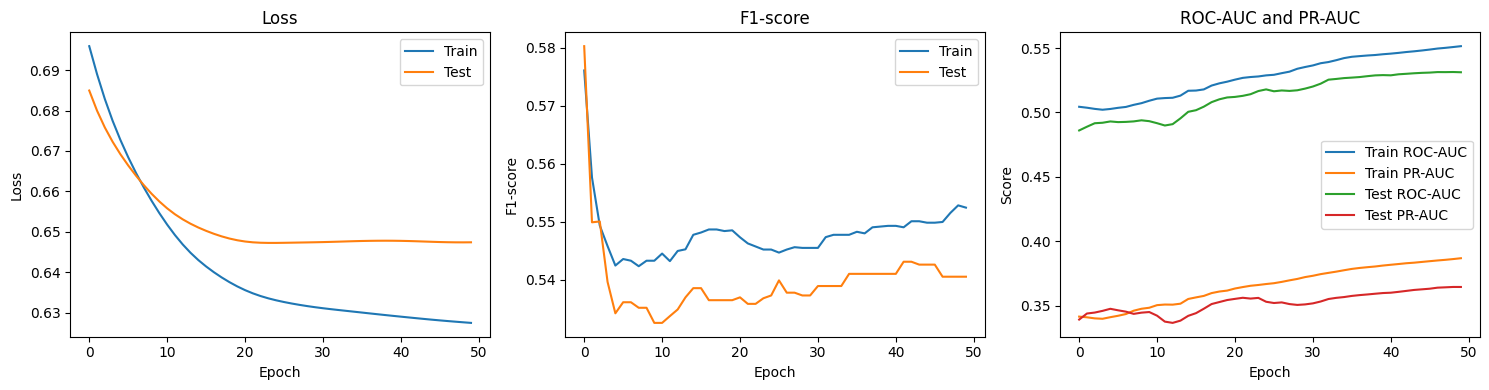

In [38]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_history, label="Train")
ax1.plot(test_loss_history, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_history, label="Train")
ax2.plot(test_f1_history, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_history, label="Train ROC-AUC")
ax3.plot(train_pr_auc_history, label="Train PR-AUC")
ax3.plot(test_roc_auc_history, label="Test ROC-AUC")
ax3.plot(test_pr_auc_history, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [39]:
import pandas as pd
import torch
array = X
df_x = pd.DataFrame(array, columns=feature_names)

In [40]:
df_x

,Histone_CENPA,Histone_H1.2,Histone_H1.5,Histone_H2AK119Ub,Histone_H2AK120Ub,Histone_H2A.X,Histone_H2A.XS139ph,Histone_H2A.Zac,Histone_H2A.Z,Histone_H2BK20ac,...,Histone_H3K14ac,Histone_H3K14cr,Histone_H3K18ac,Histone_H3K23ac,Histone_H3K27me1,Histone_H3K27me2,Histone_H3K28ac,Histone_H3K29ac,Histone_H3,Histone_H3K27me3
0,-0.030459,-0.064514,-0.047231,0.370753,-0.028818,-0.040971,-0.036012,-0.038020,0.723448,-0.153671,...,-0.113852,-0.046145,0.001348,-0.070953,-0.088654,-0.013759,-0.157899,-0.08107,1.704822,0.521534
1,-0.030459,-0.064514,-0.047231,-0.254783,-0.028818,-0.040971,-0.036012,-0.191099,-0.239074,-0.153671,...,-0.113852,-0.046145,-0.225629,-0.070953,0.256418,-0.013759,-0.157899,-0.08107,-0.165309,0.119446
2,-0.030459,-0.064514,-0.047231,-0.254783,-0.028818,-0.040971,-0.036012,-0.191099,-0.239074,-0.153671,...,-0.113852,-0.046145,0.306840,-0.070953,-0.088654,-0.013759,-0.157899,-0.08107,-0.003643,0.053289
3,-0.030459,-0.064514,-0.047231,-0.254783,-0.028818,-0.040971,-0.036012,-0.191099,-0.239074,-0.153671,...,-0.113852,-0.046145,-0.225629,-0.070953,0.913465,-0.013759,-0.157899,-0.08107,2.992125,-0.316275
4,-0.030459,-0.064514,-0.047231,-0.254783,-0.028818,-0.040971,-0.036012,-0.191099,-0.239074,-0.153671,...,-0.113852,-0.046145,-0.225629,-0.070953,-0.088654,-0.013759,-0.157899,-0.08107,-0.393626,-0.349137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5278,-0.030459,-0.064514,0.823279,-0.254783,-0.028818,-0.040971,-0.036012,-0.191099,-0.239074,-0.153671,...,-0.113852,-0.046145,-0.225629,-0.070953,-0.088654,-0.013759,-0.157899,-0.08107,-0.710746,-0.668956
5279,-0.030459,-0.064514,-0.047231,-0.254783,-0.028818,-0.040971,-0.036012,-0.191099,-0.239074,-0.153671,...,-0.113852,-0.046145,-0.225629,-0.070953,-0.088654,-0.013759,-0.157899,-0.08107,-0.710746,-0.771440
5280,-0.030459,-0.064514,-0.047231,-0.254783,-0.028818,-0.040971,-0.036012,1.436625,0.880839,-0.153671,...,-0.113852,-0.046145,0.163464,-0.070953,-0.088654,-0.013759,-0.157899,-0.08107,0.088715,-0.117990
5281,-0.030459,-0.064514,-0.047231,-0.254783,-0.028818,-0.040971,-0.036012,-0.191099,-0.239074,-0.153671,...,-0.113852,-0.046145,-0.225629,-0.070953,-0.088654,-0.013759,-0.157899,-0.08107,-0.062710,-0.013148


In [41]:
array = y.numpy()
df_y = pd.DataFrame(array, columns=['target'])

In [42]:
df_y

,target
0,1
1,1
2,1
3,0
4,1
...,...
5278,1
5279,0
5280,0
5281,0


In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(df_x, df_y)
importances = rf.feature_importances_
for feature, importance in zip(df_x.columns, importances):
    print(f'{feature}: {importance}')

/tmp/ipykernel_2061/162895947.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_x, df_y)


Histone_CENPA: 0.00027302743524104434
Histone_H1.2: 0.005458876406817866
Histone_H1.5: 0.0032317125070631964
Histone_H2AK119Ub: 0.035022797685254375
Histone_H2AK120Ub: 6.867349225219542e-05
Histone_H2A.X: 0.0027487969949058343
Histone_H2A.XS139ph: 0.0008150910752687667
Histone_H2A.Zac: 0.023082028021452157
Histone_H2A.Z: 0.05629434696313581
Histone_H2BK20ac: 0.01844770977324738
Histone_H2Bub: 0.00470728132675754
Histone_H2: 0.0007578654881401564
Histone_H3.3: 0.009399243139154018
Histone_H3K122ac: 0.04461577635730541
Histone_H3K14ac: 0.003177106399039627
Histone_H3K14cr: 0.0009706926259256963
Histone_H3K18ac: 0.0426935278601863
Histone_H3K23ac: 0.0013912145511176172
Histone_H3K27me1: 0.017780999535650276
Histone_H3K27me2: 5.0775580821174076e-05
Histone_H3K28ac: 0.011258032501367707
Histone_H3K29ac: 0.0056844307901414
Histone_H3: 0.25078962446487574
Histone_H3K27me3: 0.4612803690248788


In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC: {pr_auc:.4f}')


/tmp/ipykernel_2061/4292731798.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


F1-score: 0.2082
ROC-AUC: 0.4651
PR-AUC: 0.3578


                feature  importance
23     Histone_H3K27me3    0.459211
22           Histone_H3    0.252859
8         Histone_H2A.Z    0.057600
13     Histone_H3K122ac    0.046157
16      Histone_H3K18ac    0.042337
3     Histone_H2AK119Ub    0.035092
7       Histone_H2A.Zac    0.023973
9      Histone_H2BK20ac    0.018351
18     Histone_H3K27me1    0.016480
20      Histone_H3K28ac    0.011085
12         Histone_H3.3    0.009499
1          Histone_H1.2    0.005669
21      Histone_H3K29ac    0.004363
10        Histone_H2Bub    0.004251
14      Histone_H3K14ac    0.003725
2          Histone_H1.5    0.003389
5         Histone_H2A.X    0.002169
17      Histone_H3K23ac    0.001105
15      Histone_H3K14cr    0.001022
6   Histone_H2A.XS139ph    0.000742
11           Histone_H2    0.000463
0         Histone_CENPA    0.000321
4     Histone_H2AK120Ub    0.000099
19     Histone_H3K27me2    0.000040


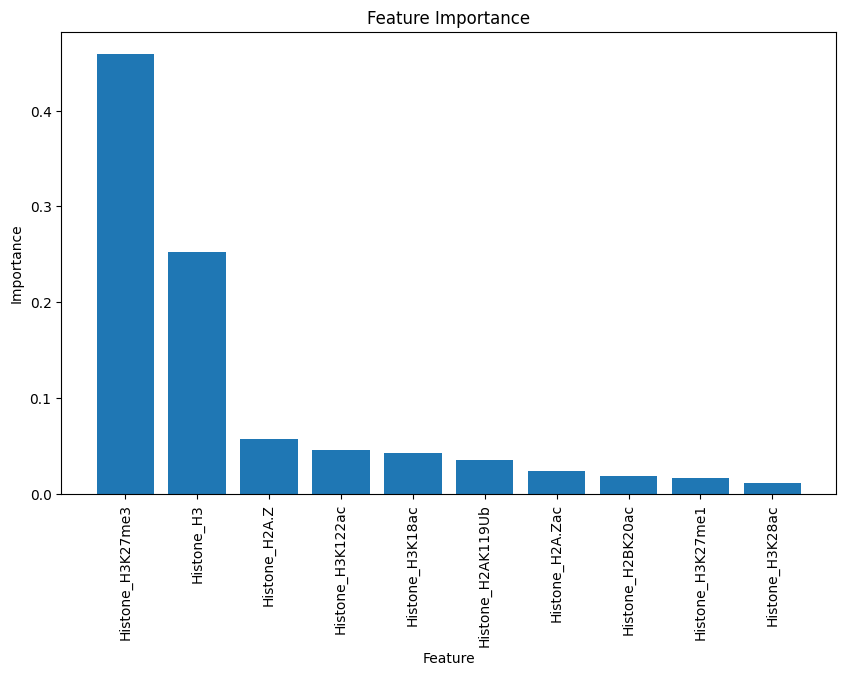

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [46]:
import catboost as cb
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
model = cb.CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1,
    depth=6, 
    random_seed=42,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
pr_roc = average_precision_score(y_test, y_pred)

print(f"F1: {f1}, AUC-ROC: {auc_roc}, PR-ROC: {pr_roc}")

0:	learn: 0.6806229	total: 49.7ms	remaining: 49.6s
1:	learn: 0.6709827	total: 50.8ms	remaining: 25.4s
2:	learn: 0.6634603	total: 51.8ms	remaining: 17.2s
3:	learn: 0.6573433	total: 52.7ms	remaining: 13.1s
4:	learn: 0.6519623	total: 54.1ms	remaining: 10.8s
5:	learn: 0.6478813	total: 55.2ms	remaining: 9.15s
6:	learn: 0.6438753	total: 56.3ms	remaining: 7.98s
7:	learn: 0.6408123	total: 57.4ms	remaining: 7.11s
8:	learn: 0.6380342	total: 58.6ms	remaining: 6.45s
9:	learn: 0.6358560	total: 59.6ms	remaining: 5.9s
10:	learn: 0.6344768	total: 60.7ms	remaining: 5.46s
11:	learn: 0.6328108	total: 61.9ms	remaining: 5.09s
12:	learn: 0.6314487	total: 63ms	remaining: 4.78s
13:	learn: 0.6307391	total: 63.8ms	remaining: 4.5s
14:	learn: 0.6296834	total: 64.9ms	remaining: 4.26s
15:	learn: 0.6282277	total: 66ms	remaining: 4.06s
16:	learn: 0.6271825	total: 67.1ms	remaining: 3.88s
17:	learn: 0.6266374	total: 68.1ms	remaining: 3.72s
18:	learn: 0.6259643	total: 69.2ms	remaining: 3.57s
19:	learn: 0.6249448	total: 

172:	learn: 0.5632086	total: 246ms	remaining: 1.17s
173:	learn: 0.5628676	total: 247ms	remaining: 1.17s
174:	learn: 0.5624383	total: 248ms	remaining: 1.17s
175:	learn: 0.5617882	total: 250ms	remaining: 1.17s
176:	learn: 0.5616042	total: 251ms	remaining: 1.17s
177:	learn: 0.5610858	total: 252ms	remaining: 1.16s
178:	learn: 0.5606628	total: 253ms	remaining: 1.16s
179:	learn: 0.5603554	total: 254ms	remaining: 1.16s
180:	learn: 0.5603046	total: 255ms	remaining: 1.15s
181:	learn: 0.5600615	total: 256ms	remaining: 1.15s
182:	learn: 0.5597500	total: 257ms	remaining: 1.15s
183:	learn: 0.5591173	total: 258ms	remaining: 1.15s
184:	learn: 0.5589252	total: 259ms	remaining: 1.14s
185:	learn: 0.5584526	total: 261ms	remaining: 1.14s
186:	learn: 0.5580579	total: 262ms	remaining: 1.14s
187:	learn: 0.5577005	total: 263ms	remaining: 1.14s
188:	learn: 0.5576216	total: 264ms	remaining: 1.13s
189:	learn: 0.5575157	total: 265ms	remaining: 1.13s
190:	learn: 0.5571941	total: 267ms	remaining: 1.13s
191:	learn: 

344:	learn: 0.5148336	total: 441ms	remaining: 838ms
345:	learn: 0.5147710	total: 442ms	remaining: 836ms
346:	learn: 0.5146063	total: 443ms	remaining: 834ms
347:	learn: 0.5143747	total: 445ms	remaining: 833ms
348:	learn: 0.5140976	total: 446ms	remaining: 832ms
349:	learn: 0.5139009	total: 447ms	remaining: 830ms
350:	learn: 0.5137470	total: 448ms	remaining: 828ms
351:	learn: 0.5136632	total: 449ms	remaining: 827ms
352:	learn: 0.5134130	total: 450ms	remaining: 825ms
353:	learn: 0.5130941	total: 451ms	remaining: 824ms
354:	learn: 0.5129017	total: 452ms	remaining: 822ms
355:	learn: 0.5128417	total: 454ms	remaining: 821ms
356:	learn: 0.5126088	total: 455ms	remaining: 819ms
357:	learn: 0.5124299	total: 456ms	remaining: 818ms
358:	learn: 0.5122476	total: 457ms	remaining: 816ms
359:	learn: 0.5120638	total: 458ms	remaining: 815ms
360:	learn: 0.5118444	total: 459ms	remaining: 813ms
361:	learn: 0.5116701	total: 460ms	remaining: 811ms
362:	learn: 0.5113654	total: 461ms	remaining: 810ms
363:	learn: 

515:	learn: 0.4856071	total: 636ms	remaining: 596ms
516:	learn: 0.4854794	total: 637ms	remaining: 595ms
517:	learn: 0.4853346	total: 639ms	remaining: 594ms
518:	learn: 0.4853281	total: 640ms	remaining: 593ms
519:	learn: 0.4851990	total: 641ms	remaining: 592ms
520:	learn: 0.4851193	total: 642ms	remaining: 590ms
521:	learn: 0.4848191	total: 643ms	remaining: 589ms
522:	learn: 0.4846751	total: 644ms	remaining: 588ms
523:	learn: 0.4845907	total: 645ms	remaining: 586ms
524:	learn: 0.4845510	total: 646ms	remaining: 585ms
525:	learn: 0.4845261	total: 648ms	remaining: 584ms
526:	learn: 0.4842056	total: 649ms	remaining: 582ms
527:	learn: 0.4840791	total: 650ms	remaining: 581ms
528:	learn: 0.4840241	total: 651ms	remaining: 580ms
529:	learn: 0.4838425	total: 652ms	remaining: 579ms
530:	learn: 0.4838171	total: 654ms	remaining: 577ms
531:	learn: 0.4836808	total: 655ms	remaining: 576ms
532:	learn: 0.4834290	total: 656ms	remaining: 575ms
533:	learn: 0.4833747	total: 657ms	remaining: 573ms
534:	learn: 

687:	learn: 0.4622085	total: 832ms	remaining: 377ms
688:	learn: 0.4620333	total: 833ms	remaining: 376ms
689:	learn: 0.4619228	total: 834ms	remaining: 375ms
690:	learn: 0.4618322	total: 835ms	remaining: 373ms
691:	learn: 0.4616979	total: 836ms	remaining: 372ms
692:	learn: 0.4615300	total: 837ms	remaining: 371ms
693:	learn: 0.4614962	total: 838ms	remaining: 370ms
694:	learn: 0.4614691	total: 839ms	remaining: 368ms
695:	learn: 0.4612983	total: 841ms	remaining: 367ms
696:	learn: 0.4610865	total: 842ms	remaining: 366ms
697:	learn: 0.4610287	total: 843ms	remaining: 365ms
698:	learn: 0.4608473	total: 844ms	remaining: 363ms
699:	learn: 0.4608077	total: 845ms	remaining: 362ms
700:	learn: 0.4606947	total: 846ms	remaining: 361ms
701:	learn: 0.4606172	total: 847ms	remaining: 360ms
702:	learn: 0.4605327	total: 849ms	remaining: 359ms
703:	learn: 0.4604247	total: 850ms	remaining: 357ms
704:	learn: 0.4603349	total: 851ms	remaining: 356ms
705:	learn: 0.4601400	total: 852ms	remaining: 355ms
706:	learn: 

862:	learn: 0.4427547	total: 1.03s	remaining: 163ms
863:	learn: 0.4427121	total: 1.03s	remaining: 162ms
864:	learn: 0.4426318	total: 1.03s	remaining: 161ms
865:	learn: 0.4425224	total: 1.03s	remaining: 159ms
866:	learn: 0.4423670	total: 1.03s	remaining: 158ms
867:	learn: 0.4423319	total: 1.03s	remaining: 157ms
868:	learn: 0.4420506	total: 1.03s	remaining: 156ms
869:	learn: 0.4420281	total: 1.03s	remaining: 155ms
870:	learn: 0.4418624	total: 1.03s	remaining: 153ms
871:	learn: 0.4417612	total: 1.04s	remaining: 152ms
872:	learn: 0.4417552	total: 1.04s	remaining: 151ms
873:	learn: 0.4417084	total: 1.04s	remaining: 150ms
874:	learn: 0.4416490	total: 1.04s	remaining: 149ms
875:	learn: 0.4416221	total: 1.04s	remaining: 147ms
876:	learn: 0.4413682	total: 1.04s	remaining: 146ms
877:	learn: 0.4413445	total: 1.04s	remaining: 145ms
878:	learn: 0.4412894	total: 1.04s	remaining: 144ms
879:	learn: 0.4411274	total: 1.04s	remaining: 142ms
880:	learn: 0.4410536	total: 1.05s	remaining: 141ms
881:	learn: 

In [47]:
feature_importances = model.feature_importances_
for feature_name, feature_importance in zip(df_x.columns, feature_importances):
    print(f"{feature_name}: {feature_importance}")

Histone_CENPA: 0.038081271628394794
Histone_H1.2: 0.8761271862756695
Histone_H1.5: 0.5032361110807722
Histone_H2AK119Ub: 6.279618165121494
Histone_H2AK120Ub: 0.010108617159773313
Histone_H2A.X: 0.2952427585169818
Histone_H2A.XS139ph: 0.149959333399558
Histone_H2A.Zac: 3.6706085158958075
Histone_H2A.Z: 10.571405267353192
Histone_H2BK20ac: 3.219266578174726
Histone_H2Bub: 0.5504759466901462
Histone_H2: 0.053586974297907826
Histone_H3.3: 1.1984195269039761
Histone_H3K122ac: 8.72678748455906
Histone_H3K14ac: 0.4155925276467715
Histone_H3K14cr: 0.08261694387954177
Histone_H3K18ac: 8.279151107936016
Histone_H3K23ac: 0.1579068373805161
Histone_H3K27me1: 2.5105128447361933
Histone_H3K27me2: 0.0
Histone_H3K28ac: 2.5791460852200747
Histone_H3K29ac: 0.8291980816624598
Histone_H3: 23.687694749057506
Histone_H3K27me3: 25.315257085423447


                feature  importance
23     Histone_H3K27me3   25.315257
22           Histone_H3   23.687695
8         Histone_H2A.Z   10.571405
13     Histone_H3K122ac    8.726787
16      Histone_H3K18ac    8.279151
3     Histone_H2AK119Ub    6.279618
7       Histone_H2A.Zac    3.670609
9      Histone_H2BK20ac    3.219267
20      Histone_H3K28ac    2.579146
18     Histone_H3K27me1    2.510513
12         Histone_H3.3    1.198420
1          Histone_H1.2    0.876127
21      Histone_H3K29ac    0.829198
10        Histone_H2Bub    0.550476
2          Histone_H1.5    0.503236
14      Histone_H3K14ac    0.415593
5         Histone_H2A.X    0.295243
17      Histone_H3K23ac    0.157907
6   Histone_H2A.XS139ph    0.149959
15      Histone_H3K14cr    0.082617
11           Histone_H2    0.053587
0         Histone_CENPA    0.038081
4     Histone_H2AK120Ub    0.010109
19     Histone_H3K27me2    0.000000


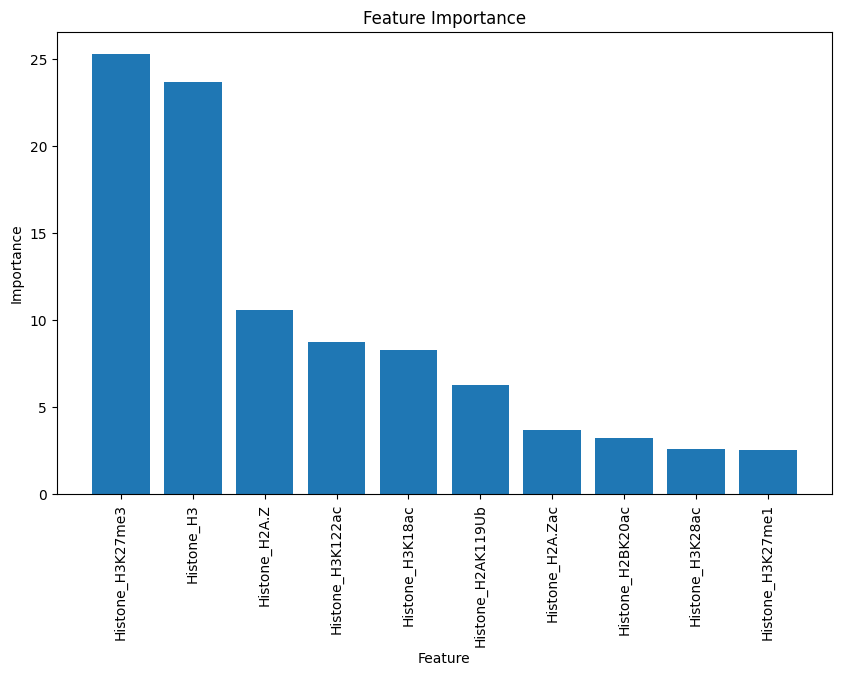

In [48]:

importances = feature_importances
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
